In [1]:
pip install ale-py gym gym[Atari] tensorflow matplotlib pyglet ipywidgets IPython imageio-ffmpeg

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
import random
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from itertools import islice
from ipywidgets import Output, GridspecLayout
from IPython import display
import glob
from gym.wrappers import Monitor

In [3]:
env = gym.make('SpaceInvaders-v4')
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

In [4]:
state_shape = env.observation_space.shape
action_shape = env.action_space.n

In [5]:
#################################################################################
# Hyperparameters

BATCH_SIZE = 128
REPLAY_SIZE = 2000
EPISODES = 800
TARGET_MODEL_UPDATE = 200
REPLAY_MEMORY = 50_000

# CNN model params
LEARNING_RATE = 0.00025
KERNEL_SIZE = [8,4,3]
STRIDES = [4,2,1]
POOL_SIZE = 2

# Q-learning params
Q_LEARNING_RATE = 0.8
DISCOUNT_FACTOR = 0.97

In [6]:
#################################################################################
# Metrics to plot

fit_metrics = ['loss', 'mean_squared_error', 'logcosh', 'cosine_similarity', 'categorical_crossentropy']
fit_history = dict((metric, []) for metric in fit_metrics)
fit_history_ep_avg = dict((metric, []) for metric in fit_metrics)
fit_history_score = []

# Plot training data
def plot():
    for key in fit_metrics:
        plt.plot(fit_history_ep_avg[key])
        plt.title('model '+key)
        plt.ylabel(key)
        plt.xlabel('episode')
        plt.show()
    plt.plot(fit_history_score)
    plt.title('model reward distribution')
    plt.ylabel('score')
    plt.xlabel('episode')
    plt.show()

# update metrics average
def update_history_avg():
    for key in fit_metrics:
        avg = np.average(fit_history[key])
        fit_history_ep_avg[key].append(avg)
        fit_history[key] = []

# update score/reward distribution
def update_history_score(score):
    fit_history_score.append(score)


In [7]:
#################################################################################
# Model - Create a convolutional neural network with Keras

def network(state_shape, action_shape):
    
    #     initializer = keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal')
    #     initializer = keras.initializers.HeUniform()
    initializer = keras.initializers.GlorotUniform()
    model = keras.Sequential()

    # Input layer
    model.add(keras.layers.Conv2D(32, kernel_size=KERNEL_SIZE[0], input_shape=(4,85,80,1), activation='relu', 
        padding='same', strides=STRIDES[0], kernel_initializer=initializer))
    #model.add(keras.layers.MaxPooling2D(pool_size=POOL_SIZE))

    # Hidden convolutional layers
    model.add(keras.layers.Conv2D(64, kernel_size=KERNEL_SIZE[1], activation='relu', padding='same', 
        strides=STRIDES[1], kernel_initializer=initializer))
    #model.add(keras.layers.MaxPooling2D(pool_size=POOL_SIZE))
    model.add(keras.layers.Conv2D(64, kernel_size=KERNEL_SIZE[2], activation='relu', padding='same', 
        strides=STRIDES[2], kernel_initializer=initializer))
    #model.add(keras.layers.MaxPooling2D(pool_size=POOL_SIZE))

    # Flatten and use fully connected network
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu', kernel_initializer=initializer))

    # Output layer
    model.add(keras.layers.Dense(action_shape, activation='softmax'))

    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
        metrics=[keras.metrics.MeanSquaredError(), keras.metrics.LogCoshError(), keras.metrics.CosineSimilarity(), keras.metrics.CategoricalCrossentropy()])
    
    return model

In [8]:
model = network(state_shape, action_shape)
target_model = network(state_shape, action_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 22, 20, 32)     2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 11, 10, 64)     32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 11, 10, 64)     36928     
                                                                 
 flatten (Flatten)           (None, 28160)             0         
                                                                 
 dense (Dense)               (None, 512)               14418432  
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14,493,350
Trainable params: 14,493,350
No

In [9]:
#################################################################################
# Preprocessing

def preprocess(obs, normalize=False):
    # Crop out score and floor
    img = obs[25:195]  

    # Downsize
    img = img[::2, ::2]

    # Take greyscale (black and white)
    img = img.mean(axis=2)  

    # color = np.array([210, 164, 74]).mean()
    # img[img==color] = 0  
    # img[img==144] = 0
    # img[img==109] = 0
    img[img != 0] = 1

    # Is this needed? normalize the image from -1 to +1  
    # No difference visually but tensor is different
    if normalize:
        img = (img - 128) / 128 - 1  

    # print("before: ", obs.shape)
    # print("after: ", img.shape)

    # reshape to 1D tensor
    return img.reshape(85,80,1)

# frame stacking
# https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
# https://arxiv.org/pdf/1312.5602.pdf
# need to get overlapping sets of frames
# Ex: X1, X2, ... , X7 -> [X1, X2, X3, X4], [X2, X3, X4, X5], ... , [X4, X5, X6, X7]

frame_skip = 4 # only one every four screenshot is considered. If there is no subsampling, not enough information to discern motion
frame_stack_size = 4

def stack_frames(stacked_frames, state, is_new):
    frame = preprocess(state)
    if is_new: # new episode
        # replace stacked_frames with 4 copies of current frame
        for i in range(frame_stack_size):
            stacked_frames.append(frame)
    else:
        # take elementwise maxima of newest frame in stacked_frames and frame
        stacked_frames.append(np.maximum(stacked_frames[3],frame))
    stacked_state = np.stack(stacked_frames)
    return stacked_state, stacked_frames

In [10]:
#################################################################################
# Training agent

def train(env, replay_memory, model, target_model, epoch):

    if len(replay_memory) <= REPLAY_SIZE:
        return

    batch = random.sample(replay_memory, BATCH_SIZE)
    states = np.array([step[0] for step in batch])
    q_values = model.predict(states)
    succesive_states = np.array([step[3] for step in batch])
    succesive_q_values = target_model.predict(succesive_states)

    X_train = []
    Y_train = []
    
    #Decay the q-learning rate (aplha) at each epoch
    alpha = max(0.001, Q_LEARNING_RATE - (Q_LEARNING_RATE - 0.001) * (epoch / 100000))
    
    for i, (state, action, reward, new_state, dead) in enumerate(batch):
        if not dead:
            # Bellman Equation : r(s) + gamma * max_a'(Q(s',a'))
            qValue = reward + DISCOUNT_FACTOR * np.max(succesive_q_values[i])
        else:
            # Pick reward as the episode has ended; no succesive state
            qValue = -1
        
        # TODO: Figure out y_train values work or not
        # Temporal Difference
        # q_value_arr for a state s : [qVal action1, qval action1, ..., qval action18] 
        q_value_arr = q_values[i]
        # Qvalue for action a  : Q(s,a) + alpha(r(s) + gamma*max_a'(Q(s',a')) - Q(s, a))         
        # q_value_arr[action] = (1 - Q_LEARNING_RATE) * q_value_arr[action] + Q_LEARNING_RATE * qValue
        q_value_arr[action] = q_value_arr[action] + alpha * (qValue - q_value_arr[action])

        X_train.append(state)
        Y_train.append(q_value_arr)
    
    if epoch % 250 == 0:
        checkpoint_filepath = "./tmp/cp.ckpt"

        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            save_best_only=True,
            verbose=1,
            save_freq=1,
            monitor='mean_squared_error',
            mode='min')
        
        %store fit_history
        %store fit_history_ep_avg
        %store fit_history_score

        # Model weights are saved if it's the best seen so far.
        history = model.fit(np.array(X_train), np.array(Y_train), batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback]) 
    else:
        history = model.fit(np.array(X_train), np.array(Y_train), batch_size=BATCH_SIZE)

    for key in history.history.keys():
        fit_history[key].append(history.history[key][0]) # since model.fit with default num epochs = 1

#     # The model weights (that are considered the best) are loaded into the model.
#     model.load_weights(checkpoint_filepath)

In [ ]:
#################################################################################
# Deep Q-Learning agent

epsilon = 1
eps_min = 0.05
eps_max = 1
decay = 0.015

model = network(state_shape, action_shape)
# model = keras.models.load_model("models/model1.0")
target_model = network(state_shape, action_shape)
target_model.set_weights(model.get_weights())

# initialize with zeroes
stacked_frames = deque(maxlen = frame_stack_size)
for i in range(frame_stack_size):
    stacked_frames.append([np.zeros((85,80), dtype=int)])

# Memory buffer to store the last N experiences
replay_memory = deque(maxlen=REPLAY_MEMORY)

update_target_counter = 0
step_counter = 0
epoch = 0

for episode in range(EPISODES):
    state = env.reset()
    score = 0 
    done = False
    dead = False
    start_life = 3
    
    state,_,_,_ = env.step(0)
    stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)

    while not done:
        step_counter += 1
        dead = False

        # Epsilon Greedy Strategy with explore probability epsilon
        if np.random.rand() <= epsilon:
            # Explore 
            action = env.action_space.sample()
        else:
            # Exploit best action from cnn
            predictions = model.predict(np.array([stacked_state,])).flatten()
            action = np.argmax(predictions)


        new_state, reward, done, info = env.step(action)
        new_stacked_state, stacked_frames = stack_frames(stacked_frames, new_state, False)
        
        if start_life > info['lives']:
            dead = True
            start_life = info['lives']

        replay_memory.append([stacked_state, action, reward, new_stacked_state, dead])

        if step_counter % 4 == 0 or done:
            epoch += 1
            train(env, replay_memory, model, target_model, epoch)

        score += reward
        stacked_state = new_stacked_state
        state = new_state

        if update_target_counter >= TARGET_MODEL_UPDATE:
            update_target_counter = 0
            target_model.set_weights(model.get_weights())

        if done:
            print('Score: {} after episode = {}'.format(score, episode))
            update_history_avg()
            update_history_score(score)

    # Exponential Decay for epsilon (explore with atleast eps_min probability)
    epsilon = eps_min + (eps_max - eps_min) * np.exp(-decay * episode)

Score: 135.0 after episode = 0


C:\Users\zayaa\workspaces\space-invaders-ai\venv\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\zayaa\workspaces\space-invaders-ai\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Score: 150.0 after episode = 1
1/1 [==============================] - 0s 35ms/step - loss: 1.4736 - mean_squared_error: 1.4736 - logcosh: 0.0785 - cosine_similarity: 0.9741 - categorical_crossentropy: 2.4399


1/1 [==============================] - 0s 36ms/step - loss: 0.2034 - mean_squared_error: 0.2034 - logcosh: 0.0189 - cosine_similarity: 0.9896 - categorical_crossentropy: 1.9182
Score: 295.0 after episode = 2
1/1 [==============================] - 0s 48ms/step - loss: 1.7436 - mean_squared_error: 1.7436 - logcosh: 0.0890 - cosine_similarity: 0.9685 - categorical_crossentropy: 2.2913


1/1 [==============================] - 0s 46ms/step - loss: 0.3328 - mean_squared_error: 0.3328 - logcosh: 0.0248 - cosine_similarity: 0.9799 - categorical_crossentropy: 1.5042


1/1 [==============================] - 0s 48ms/step - loss: 1.4203 - mean_squared_error: 1.4203 - logcosh: 0.0797 - cosine_similarity: 0.9710 - categorical_crossentropy: 2.0015
Score: 35.0 after episode = 3
1/1 [==============================] - 0s 50ms/step - loss: 1.5729 - mean_squared_error: 1.5729 - logcosh: 0.0776 - cosine_similarity: 0.9739 - categorical_crossentropy: 2.1268


1/1 [==============================] - 0s 38ms/step - loss: 0.5177 - mean_squared_error: 0.5177 - logcosh: 0.0295 - cosine_similarity: 0.9871 - categorical_crossentropy: 1.6735


1/1 [==============================] - 0s 37ms/step - loss: 0.3130 - mean_squared_error: 0.3130 - logcosh: 0.0210 - cosine_similarity: 0.9875 - categorical_crossentropy: 1.4719
Score: 65.0 after episode = 4
1/1 [==============================] - 0s 39ms/step - loss: 0.1890 - mean_squared_error: 0.1890 - logcosh: 0.0163 - cosine_similarity: 0.9762 - categorical_crossentropy: 1.6716
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.02174, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.2721 - mean_squared_error: 0.2721 - logcosh: 0.0259 - cosine_similarity: 0.9762 - categorical_crossentropy: 1.7457


1/1 [==============================] - 0s 50ms/step - loss: 0.7870 - mean_squared_error: 0.7870 - logcosh: 0.0511 - cosine_similarity: 0.9720 - categorical_crossentropy: 2.1982


1/1 [==============================] - 0s 57ms/step - loss: 1.1034 - mean_squared_error: 1.1034 - logcosh: 0.0633 - cosine_similarity: 0.9724 - categorical_crossentropy: 2.1427


1/1 [==============================] - 0s 59ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - logcosh: 0.0068 - cosine_similarity: 0.9844 - categorical_crossentropy: 1.5297


1/1 [==============================] - 0s 34ms/step - loss: 0.5678 - mean_squared_error: 0.5678 - logcosh: 0.0364 - cosine_similarity: 0.9675 - categorical_crossentropy: 1.5976
Score: 120.0 after episode = 5
1/1 [==============================] - 0s 40ms/step - loss: 0.4826 - mean_squared_error: 0.4826 - logcosh: 0.0255 - cosine_similarity: 0.9840 - categorical_crossentropy: 1.4809


1/1 [==============================] - 0s 38ms/step - loss: 0.2444 - mean_squared_error: 0.2444 - logcosh: 0.0282 - cosine_similarity: 0.9715 - categorical_crossentropy: 1.8813
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.72577, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - logcosh: 0.0068 - cosine_similarity: 0.9741 - categorical_crossentropy: 1.4798


1/1 [==============================] - 0s 34ms/step - loss: 0.2044 - mean_squared_error: 0.2044 - logcosh: 0.0285 - cosine_similarity: 0.9714 - categorical_crossentropy: 1.7943


1/1 [==============================] - 0s 47ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - logcosh: 0.0109 - cosine_similarity: 0.9819 - categorical_crossentropy: 1.5136
Score: 125.0 after episode = 6
1/1 [==============================] - 0s 35ms/step - loss: 1.4990 - mean_squared_error: 1.4990 - logcosh: 0.0793 - cosine_similarity: 0.9780 - categorical_crossentropy: 1.4485


1/1 [==============================] - 0s 45ms/step - loss: 0.1856 - mean_squared_error: 0.1856 - logcosh: 0.0163 - cosine_similarity: 0.9823 - categorical_crossentropy: 1.5648


1/1 [==============================] - 0s 33ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - logcosh: 0.0114 - cosine_similarity: 0.9811 - categorical_crossentropy: 1.5150


1/1 [==============================] - 0s 33ms/step - loss: 1.1800 - mean_squared_error: 1.1800 - logcosh: 0.0552 - cosine_similarity: 0.9828 - categorical_crossentropy: 1.5014


1/1 [==============================] - 0s 36ms/step - loss: 0.6025 - mean_squared_error: 0.6025 - logcosh: 0.0503 - cosine_similarity: 0.9510 - categorical_crossentropy: 1.9701
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.36342, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 42ms/step - loss: 0.5969 - mean_squared_error: 0.5969 - logcosh: 0.0362 - cosine_similarity: 0.9759 - categorical_crossentropy: 1.9413
Score: 180.0 after episode = 7
1/1 [==============================] - 0s 47ms/step - loss: 0.8353 - mean_squared_error: 0.8353 - logcosh: 0.0501 - cosine_similarity: 0.9702 - categorical_crossentropy: 1.8629


1/1 [==============================] - 0s 36ms/step - loss: 1.0963 - mean_squared_error: 1.0963 - logcosh: 0.0601 - cosine_similarity: 0.9758 - categorical_crossentropy: 1.6477


1/1 [==============================] - 0s 37ms/step - loss: 0.1635 - mean_squared_error: 0.1635 - logcosh: 0.0200 - cosine_similarity: 0.9801 - categorical_crossentropy: 1.6612


1/1 [==============================] - 0s 40ms/step - loss: 0.1734 - mean_squared_error: 0.1734 - logcosh: 0.0165 - cosine_similarity: 0.9801 - categorical_crossentropy: 1.4692
Score: 180.0 after episode = 8
1/1 [==============================] - 0s 39ms/step - loss: 0.3335 - mean_squared_error: 0.3335 - logcosh: 0.0221 - cosine_similarity: 0.9839 - categorical_crossentropy: 1.9809


1/1 [==============================] - 0s 40ms/step - loss: 0.8920 - mean_squared_error: 0.8920 - logcosh: 0.0576 - cosine_similarity: 0.9724 - categorical_crossentropy: 1.7668


1/1 [==============================] - 0s 54ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - logcosh: 0.0116 - cosine_similarity: 0.9859 - categorical_crossentropy: 1.2928
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.98774, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 41ms/step - loss: 0.5688 - mean_squared_error: 0.5688 - logcosh: 0.0487 - cosine_similarity: 0.9779 - categorical_crossentropy: 1.3560


1/1 [==============================] - 0s 37ms/step - loss: 1.0292 - mean_squared_error: 1.0292 - logcosh: 0.0532 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.5530
Score: 135.0 after episode = 9
1/1 [==============================] - 0s 45ms/step - loss: 0.5044 - mean_squared_error: 0.5044 - logcosh: 0.0316 - cosine_similarity: 0.9792 - categorical_crossentropy: 1.3605


1/1 [==============================] - 0s 40ms/step - loss: 0.9494 - mean_squared_error: 0.9494 - logcosh: 0.0508 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.3408


1/1 [==============================] - 0s 51ms/step - loss: 0.3019 - mean_squared_error: 0.3019 - logcosh: 0.0214 - cosine_similarity: 0.9839 - categorical_crossentropy: 1.2262


1/1 [==============================] - 0s 39ms/step - loss: 0.4270 - mean_squared_error: 0.4270 - logcosh: 0.0401 - cosine_similarity: 0.9736 - categorical_crossentropy: 1.7737


1/1 [==============================] - 0s 40ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - logcosh: 0.0162 - cosine_similarity: 0.9842 - categorical_crossentropy: 1.3754


1/1 [==============================] - 0s 44ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - logcosh: 0.0021 - cosine_similarity: 0.9799 - categorical_crossentropy: 1.4361
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.47485, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 40ms/step - loss: 0.6930 - mean_squared_error: 0.6930 - logcosh: 0.0314 - cosine_similarity: 0.9877 - categorical_crossentropy: 1.3515
Score: 235.0 after episode = 10
1/1 [==============================] - 0s 36ms/step - loss: 0.4937 - mean_squared_error: 0.4937 - logcosh: 0.0479 - cosine_similarity: 0.9822 - categorical_crossentropy: 1.6726


1/1 [==============================] - 0s 38ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - logcosh: 0.0017 - cosine_similarity: 0.9860 - categorical_crossentropy: 1.3856


1/1 [==============================] - 0s 55ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - logcosh: 0.0120 - cosine_similarity: 0.9830 - categorical_crossentropy: 1.5837


1/1 [==============================] - 0s 50ms/step - loss: 0.1891 - mean_squared_error: 0.1891 - logcosh: 0.0251 - cosine_similarity: 0.9707 - categorical_crossentropy: 1.9460


1/1 [==============================] - 0s 40ms/step - loss: 0.3963 - mean_squared_error: 0.3963 - logcosh: 0.0319 - cosine_similarity: 0.9768 - categorical_crossentropy: 1.4007
Score: 110.0 after episode = 11
1/1 [==============================] - 0s 36ms/step - loss: 0.4779 - mean_squared_error: 0.4779 - logcosh: 0.0280 - cosine_similarity: 0.9764 - categorical_crossentropy: 1.2440


1/1 [==============================] - 0s 49ms/step - loss: 0.2729 - mean_squared_error: 0.2729 - logcosh: 0.0323 - cosine_similarity: 0.9537 - categorical_crossentropy: 1.4444
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.47520, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 36ms/step - loss: 0.3238 - mean_squared_error: 0.3238 - logcosh: 0.0269 - cosine_similarity: 0.9784 - categorical_crossentropy: 1.2880


1/1 [==============================] - 0s 54ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - logcosh: 0.0028 - cosine_similarity: 0.9798 - categorical_crossentropy: 1.3402


1/1 [==============================] - 0s 38ms/step - loss: 0.7558 - mean_squared_error: 0.7558 - logcosh: 0.0402 - cosine_similarity: 0.9767 - categorical_crossentropy: 1.3652
Score: 120.0 after episode = 12
1/1 [==============================] - 0s 48ms/step - loss: 0.0893 - mean_squared_error: 0.0893 - logcosh: 0.0127 - cosine_similarity: 0.9790 - categorical_crossentropy: 1.7948


1/1 [==============================] - 0s 41ms/step - loss: 1.0271 - mean_squared_error: 1.0271 - logcosh: 0.0552 - cosine_similarity: 0.9765 - categorical_crossentropy: 1.7302


1/1 [==============================] - 0s 40ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - logcosh: 0.0110 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.4254


1/1 [==============================] - 0s 39ms/step - loss: 1.1650 - mean_squared_error: 1.1650 - logcosh: 0.0578 - cosine_similarity: 0.9881 - categorical_crossentropy: 1.4370


1/1 [==============================] - 0s 54ms/step - loss: 0.1669 - mean_squared_error: 0.1669 - logcosh: 0.0159 - cosine_similarity: 0.9854 - categorical_crossentropy: 1.2658
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.68376, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 49ms/step - loss: 0.1614 - mean_squared_error: 0.1614 - logcosh: 0.0205 - cosine_similarity: 0.9772 - categorical_crossentropy: 1.5488


1/1 [==============================] - 0s 37ms/step - loss: 1.0020 - mean_squared_error: 1.0020 - logcosh: 0.0497 - cosine_similarity: 0.9831 - categorical_crossentropy: 1.5873
Score: 155.0 after episode = 13
1/1 [==============================] - 0s 38ms/step - loss: 0.7050 - mean_squared_error: 0.7050 - logcosh: 0.0363 - cosine_similarity: 0.9717 - categorical_crossentropy: 1.4955


1/1 [==============================] - 0s 39ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - logcosh: 0.0073 - cosine_similarity: 0.9717 - categorical_crossentropy: 1.3400


1/1 [==============================] - 0s 38ms/step - loss: 0.6745 - mean_squared_error: 0.6745 - logcosh: 0.0491 - cosine_similarity: 0.9815 - categorical_crossentropy: 1.3739


1/1 [==============================] - 0s 52ms/step - loss: 0.4784 - mean_squared_error: 0.4784 - logcosh: 0.0352 - cosine_similarity: 0.9763 - categorical_crossentropy: 1.6920
Score: 155.0 after episode = 14


1/1 [==============================] - 0s 44ms/step - loss: 0.4392 - mean_squared_error: 0.4392 - logcosh: 0.0385 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.3370
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.00600, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.5168 - mean_squared_error: 0.5168 - logcosh: 0.0317 - cosine_similarity: 0.9812 - categorical_crossentropy: 1.5019


1/1 [==============================] - 0s 37ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - logcosh: 0.0023 - cosine_similarity: 0.9868 - categorical_crossentropy: 1.3220


1/1 [==============================] - 0s 57ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - logcosh: 0.0064 - cosine_similarity: 0.9845 - categorical_crossentropy: 1.3540


1/1 [==============================] - 0s 19ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - logcosh: 0.0571 - cosine_similarity: 0.9671 - categorical_crossentropy: 2.0962
Score: 140.0 after episode = 15
1/1 [==============================] - 0s 35ms/step - loss: 0.7177 - mean_squared_error: 0.7177 - logcosh: 0.0331 - cosine_similarity: 0.9647 - categorical_crossentropy: 1.7147


1/1 [==============================] - 0s 43ms/step - loss: 0.2962 - mean_squared_error: 0.2962 - logcosh: 0.0215 - cosine_similarity: 0.9833 - categorical_crossentropy: 1.2552


1/1 [==============================] - 0s 29ms/step - loss: 0.3228 - mean_squared_error: 0.3228 - logcosh: 0.0214 - cosine_similarity: 0.9799 - categorical_crossentropy: 1.7331


1/1 [==============================] - 0s 26ms/step - loss: 0.5345 - mean_squared_error: 0.5345 - logcosh: 0.0340 - cosine_similarity: 0.9879 - categorical_crossentropy: 1.3627
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.73582, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 31ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - logcosh: 0.0247 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.6260
Score: 75.0 after episode = 16
1/1 [==============================] - 0s 61ms/step - loss: 0.4646 - mean_squared_error: 0.4646 - logcosh: 0.0258 - cosine_similarity: 0.9880 - categorical_crossentropy: 1.3121


1/1 [==============================] - 0s 51ms/step - loss: 0.1986 - mean_squared_error: 0.1986 - logcosh: 0.0202 - cosine_similarity: 0.9786 - categorical_crossentropy: 1.5770


1/1 [==============================] - 0s 45ms/step - loss: 0.2010 - mean_squared_error: 0.2010 - logcosh: 0.0217 - cosine_similarity: 0.9730 - categorical_crossentropy: 1.5029
Score: 90.0 after episode = 17
1/1 [==============================] - 0s 35ms/step - loss: 0.1645 - mean_squared_error: 0.1645 - logcosh: 0.0166 - cosine_similarity: 0.9823 - categorical_crossentropy: 1.1713


1/1 [==============================] - 0s 44ms/step - loss: 0.2990 - mean_squared_error: 0.2990 - logcosh: 0.0230 - cosine_similarity: 0.9683 - categorical_crossentropy: 1.2562


1/1 [==============================] - 0s 37ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - logcosh: 0.0012 - cosine_similarity: 0.9899 - categorical_crossentropy: 1.4373


1/1 [==============================] - 0s 49ms/step - loss: 1.0165 - mean_squared_error: 1.0165 - logcosh: 0.0753 - cosine_similarity: 0.9865 - categorical_crossentropy: 1.4034
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.00475, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - logcosh: 0.0124 - cosine_similarity: 0.9803 - categorical_crossentropy: 1.5225


1/1 [==============================] - 0s 46ms/step - loss: 0.4267 - mean_squared_error: 0.4267 - logcosh: 0.0425 - cosine_similarity: 0.9826 - categorical_crossentropy: 1.4430


1/1 [==============================] - 0s 35ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - logcosh: 0.0072 - cosine_similarity: 0.9760 - categorical_crossentropy: 1.3192
Score: 120.0 after episode = 18
1/1 [==============================] - 0s 47ms/step - loss: 0.1451 - mean_squared_error: 0.1451 - logcosh: 0.0211 - cosine_similarity: 0.9839 - categorical_crossentropy: 1.2617


1/1 [==============================] - 0s 37ms/step - loss: 0.5393 - mean_squared_error: 0.5393 - logcosh: 0.0431 - cosine_similarity: 0.9824 - categorical_crossentropy: 1.4774


1/1 [==============================] - 0s 35ms/step - loss: 0.1664 - mean_squared_error: 0.1664 - logcosh: 0.0244 - cosine_similarity: 0.9660 - categorical_crossentropy: 1.5111


1/1 [==============================] - 0s 44ms/step - loss: 0.2933 - mean_squared_error: 0.2933 - logcosh: 0.0213 - cosine_similarity: 0.9877 - categorical_crossentropy: 1.2921
Score: 100.0 after episode = 19
1/1 [==============================] - 0s 50ms/step - loss: 0.1846 - mean_squared_error: 0.1846 - logcosh: 0.0274 - cosine_similarity: 0.9803 - categorical_crossentropy: 1.6346
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.07576, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 49ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - logcosh: 0.0030 - cosine_similarity: 0.9876 - categorical_crossentropy: 1.2739


1/1 [==============================] - 0s 38ms/step - loss: 0.9024 - mean_squared_error: 0.9024 - logcosh: 0.0526 - cosine_similarity: 0.9835 - categorical_crossentropy: 1.4532


1/1 [==============================] - 0s 40ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - logcosh: 0.0113 - cosine_similarity: 0.9762 - categorical_crossentropy: 1.2932


1/1 [==============================] - 0s 40ms/step - loss: 0.1787 - mean_squared_error: 0.1787 - logcosh: 0.0194 - cosine_similarity: 0.9854 - categorical_crossentropy: 1.3750


1/1 [==============================] - 0s 49ms/step - loss: 0.2906 - mean_squared_error: 0.2906 - logcosh: 0.0205 - cosine_similarity: 0.9880 - categorical_crossentropy: 1.3722


1/1 [==============================] - 0s 49ms/step - loss: 0.5582 - mean_squared_error: 0.5582 - logcosh: 0.0483 - cosine_similarity: 0.9669 - categorical_crossentropy: 1.6100


1/1 [==============================] - 0s 47ms/step - loss: 0.6058 - mean_squared_error: 0.6058 - logcosh: 0.0484 - cosine_similarity: 0.9783 - categorical_crossentropy: 1.2639
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.68978, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.4571 - mean_squared_error: 0.4571 - logcosh: 0.0251 - cosine_similarity: 0.9878 - categorical_crossentropy: 1.3116


1/1 [==============================] - 0s 49ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - logcosh: 0.0023 - cosine_similarity: 0.9880 - categorical_crossentropy: 1.2910
Score: 315.0 after episode = 20
1/1 [==============================] - 0s 30ms/step - loss: 0.9093 - mean_squared_error: 0.9093 - logcosh: 0.0629 - cosine_similarity: 0.9765 - categorical_crossentropy: 1.4760


1/1 [==============================] - 0s 42ms/step - loss: 0.3407 - mean_squared_error: 0.3407 - logcosh: 0.0331 - cosine_similarity: 0.9783 - categorical_crossentropy: 1.4469


1/1 [==============================] - 0s 33ms/step - loss: 0.4630 - mean_squared_error: 0.4630 - logcosh: 0.0260 - cosine_similarity: 0.9877 - categorical_crossentropy: 1.3966
Score: 80.0 after episode = 21


1/1 [==============================] - 0s 42ms/step - loss: 0.5128 - mean_squared_error: 0.5128 - logcosh: 0.0482 - cosine_similarity: 0.9733 - categorical_crossentropy: 1.4109


1/1 [==============================] - 0s 32ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - logcosh: 0.0074 - cosine_similarity: 0.9831 - categorical_crossentropy: 1.2769
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.02395, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - logcosh: 0.0024 - cosine_similarity: 0.9877 - categorical_crossentropy: 1.3251


1/1 [==============================] - 0s 45ms/step - loss: 0.5759 - mean_squared_error: 0.5759 - logcosh: 0.0400 - cosine_similarity: 0.9836 - categorical_crossentropy: 1.2474
Score: 75.0 after episode = 22
1/1 [==============================] - 0s 32ms/step - loss: 0.6037 - mean_squared_error: 0.6037 - logcosh: 0.0436 - cosine_similarity: 0.9829 - categorical_crossentropy: 1.4254


1/1 [==============================] - 0s 53ms/step - loss: 0.0875 - mean_squared_error: 0.0875 - logcosh: 0.0150 - cosine_similarity: 0.9730 - categorical_crossentropy: 1.3560


1/1 [==============================] - 0s 36ms/step - loss: 0.6796 - mean_squared_error: 0.6796 - logcosh: 0.0352 - cosine_similarity: 0.9801 - categorical_crossentropy: 1.2910


1/1 [==============================] - 0s 53ms/step - loss: 0.6903 - mean_squared_error: 0.6903 - logcosh: 0.0318 - cosine_similarity: 0.9847 - categorical_crossentropy: 1.4584


1/1 [==============================] - 0s 38ms/step - loss: 0.3549 - mean_squared_error: 0.3549 - logcosh: 0.0299 - cosine_similarity: 0.9885 - categorical_crossentropy: 1.1988
Score: 210.0 after episode = 23
1/1 [==============================] - 0s 38ms/step - loss: 0.8085 - mean_squared_error: 0.8085 - logcosh: 0.0536 - cosine_similarity: 0.9783 - categorical_crossentropy: 1.1877


1/1 [==============================] - 0s 38ms/step - loss: 0.4826 - mean_squared_error: 0.4826 - logcosh: 0.0309 - cosine_similarity: 0.9824 - categorical_crossentropy: 1.5498
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.03914, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 38ms/step - loss: 0.1230 - mean_squared_error: 0.1230 - logcosh: 0.0205 - cosine_similarity: 0.9677 - categorical_crossentropy: 1.5750


1/1 [==============================] - 0s 37ms/step - loss: 0.4462 - mean_squared_error: 0.4462 - logcosh: 0.0339 - cosine_similarity: 0.9871 - categorical_crossentropy: 1.3229


1/1 [==============================] - 0s 50ms/step - loss: 0.4784 - mean_squared_error: 0.4784 - logcosh: 0.0261 - cosine_similarity: 0.9796 - categorical_crossentropy: 1.5408


1/1 [==============================] - 0s 44ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - logcosh: 0.0028 - cosine_similarity: 0.9839 - categorical_crossentropy: 1.1619
Score: 235.0 after episode = 24
1/1 [==============================] - 0s 40ms/step - loss: 0.6579 - mean_squared_error: 0.6579 - logcosh: 0.0310 - cosine_similarity: 0.9881 - categorical_crossentropy: 1.2339


1/1 [==============================] - 0s 35ms/step - loss: 0.0862 - mean_squared_error: 0.0862 - logcosh: 0.0147 - cosine_similarity: 0.9871 - categorical_crossentropy: 1.3041


1/1 [==============================] - 0s 47ms/step - loss: 1.3505 - mean_squared_error: 1.3505 - logcosh: 0.0599 - cosine_similarity: 0.9797 - categorical_crossentropy: 2.0625
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.83931, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 22ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - logcosh: 0.0306 - cosine_similarity: 0.9862 - categorical_crossentropy: 1.2818


1/1 [==============================] - 0s 38ms/step - loss: 0.6363 - mean_squared_error: 0.6363 - logcosh: 0.0471 - cosine_similarity: 0.9894 - categorical_crossentropy: 1.2699


1/1 [==============================] - 0s 40ms/step - loss: 0.1673 - mean_squared_error: 0.1673 - logcosh: 0.0243 - cosine_similarity: 0.9789 - categorical_crossentropy: 1.3873


1/1 [==============================] - 0s 38ms/step - loss: 0.3637 - mean_squared_error: 0.3637 - logcosh: 0.0335 - cosine_similarity: 0.9776 - categorical_crossentropy: 1.7583


1/1 [==============================] - 0s 38ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - logcosh: 0.0499 - cosine_similarity: 0.9763 - categorical_crossentropy: 2.2445
Score: 490.0 after episode = 25


1/1 [==============================] - 0s 36ms/step - loss: 0.7350 - mean_squared_error: 0.7350 - logcosh: 0.0413 - cosine_similarity: 0.9658 - categorical_crossentropy: 1.5316


1/1 [==============================] - 0s 47ms/step - loss: 0.3561 - mean_squared_error: 0.3561 - logcosh: 0.0296 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.2600
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.11580, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 39ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - logcosh: 0.0060 - cosine_similarity: 0.9865 - categorical_crossentropy: 1.2560


1/1 [==============================] - 0s 49ms/step - loss: 0.4119 - mean_squared_error: 0.4119 - logcosh: 0.0361 - cosine_similarity: 0.9520 - categorical_crossentropy: 1.9305
Score: 85.0 after episode = 26
1/1 [==============================] - 0s 39ms/step - loss: 0.8865 - mean_squared_error: 0.8865 - logcosh: 0.0619 - cosine_similarity: 0.9746 - categorical_crossentropy: 1.8203


1/1 [==============================] - 0s 46ms/step - loss: 0.9746 - mean_squared_error: 0.9746 - logcosh: 0.0615 - cosine_similarity: 0.9875 - categorical_crossentropy: 1.2489


1/1 [==============================] - 0s 53ms/step - loss: 0.2886 - mean_squared_error: 0.2886 - logcosh: 0.0225 - cosine_similarity: 0.9723 - categorical_crossentropy: 1.2541


1/1 [==============================] - 0s 36ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - logcosh: 0.0021 - cosine_similarity: 0.9890 - categorical_crossentropy: 1.3722
Score: 85.0 after episode = 27
1/1 [==============================] - 0s 56ms/step - loss: 0.6948 - mean_squared_error: 0.6948 - logcosh: 0.0319 - cosine_similarity: 0.9776 - categorical_crossentropy: 3.5574


1/1 [==============================] - 0s 38ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - logcosh: 0.0028 - cosine_similarity: 0.9898 - categorical_crossentropy: 1.3083
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.61857, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 45ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - logcosh: 0.0068 - cosine_similarity: 0.9897 - categorical_crossentropy: 1.2937


1/1 [==============================] - 0s 49ms/step - loss: 0.3715 - mean_squared_error: 0.3715 - logcosh: 0.0304 - cosine_similarity: 0.9729 - categorical_crossentropy: 1.5325


1/1 [==============================] - 0s 49ms/step - loss: 0.0753 - mean_squared_error: 0.0753 - logcosh: 0.0134 - cosine_similarity: 0.9658 - categorical_crossentropy: 1.2044
Score: 10.0 after episode = 28
1/1 [==============================] - 0s 38ms/step - loss: 0.7140 - mean_squared_error: 0.7140 - logcosh: 0.0398 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.2703


1/1 [==============================] - 0s 41ms/step - loss: 0.5684 - mean_squared_error: 0.5684 - logcosh: 0.0529 - cosine_similarity: 0.9656 - categorical_crossentropy: 2.4034


1/1 [==============================] - 0s 34ms/step - loss: 0.9416 - mean_squared_error: 0.9416 - logcosh: 0.0525 - cosine_similarity: 0.9827 - categorical_crossentropy: 1.3810


1/1 [==============================] - 0s 40ms/step - loss: 0.4362 - mean_squared_error: 0.4362 - logcosh: 0.0399 - cosine_similarity: 0.9752 - categorical_crossentropy: 1.8536


1/1 [==============================] - 0s 39ms/step - loss: 0.3044 - mean_squared_error: 0.3044 - logcosh: 0.0250 - cosine_similarity: 0.9823 - categorical_crossentropy: 1.3709
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.99065, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 36ms/step - loss: 0.9476 - mean_squared_error: 0.9476 - logcosh: 0.0656 - cosine_similarity: 0.9849 - categorical_crossentropy: 1.2985


1/1 [==============================] - 0s 40ms/step - loss: 0.9530 - mean_squared_error: 0.9530 - logcosh: 0.0622 - cosine_similarity: 0.9741 - categorical_crossentropy: 1.5295


1/1 [==============================] - 0s 40ms/step - loss: 0.4469 - mean_squared_error: 0.4469 - logcosh: 0.0269 - cosine_similarity: 0.9894 - categorical_crossentropy: 1.2761
Score: 325.0 after episode = 29
1/1 [==============================] - 0s 48ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - logcosh: 0.0117 - cosine_similarity: 0.9708 - categorical_crossentropy: 1.3346


1/1 [==============================] - 0s 35ms/step - loss: 0.6151 - mean_squared_error: 0.6151 - logcosh: 0.0393 - cosine_similarity: 0.9817 - categorical_crossentropy: 1.8601


1/1 [==============================] - 0s 43ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - logcosh: 0.0189 - cosine_similarity: 0.9816 - categorical_crossentropy: 1.3516


1/1 [==============================] - 0s 40ms/step - loss: 0.3611 - mean_squared_error: 0.3611 - logcosh: 0.0318 - cosine_similarity: 0.9894 - categorical_crossentropy: 1.3617
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.19026, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 46ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - logcosh: 0.0129 - cosine_similarity: 0.9658 - categorical_crossentropy: 1.5095
Score: 125.0 after episode = 30
1/1 [==============================] - 0s 38ms/step - loss: 0.1785 - mean_squared_error: 0.1785 - logcosh: 0.0173 - cosine_similarity: 0.9800 - categorical_crossentropy: 1.5716


1/1 [==============================] - 0s 39ms/step - loss: 0.1636 - mean_squared_error: 0.1636 - logcosh: 0.0171 - cosine_similarity: 0.9872 - categorical_crossentropy: 1.2267


1/1 [==============================] - 0s 41ms/step - loss: 0.2105 - mean_squared_error: 0.2105 - logcosh: 0.0245 - cosine_similarity: 0.9751 - categorical_crossentropy: 1.9863


1/1 [==============================] - 0s 36ms/step - loss: 0.3451 - mean_squared_error: 0.3451 - logcosh: 0.0297 - cosine_similarity: 0.9741 - categorical_crossentropy: 2.3678


1/1 [==============================] - 0s 43ms/step - loss: 0.8658 - mean_squared_error: 0.8658 - logcosh: 0.0524 - cosine_similarity: 0.9776 - categorical_crossentropy: 2.4841
Score: 155.0 after episode = 31
1/1 [==============================] - 0s 37ms/step - loss: 0.2798 - mean_squared_error: 0.2798 - logcosh: 0.0204 - cosine_similarity: 0.9906 - categorical_crossentropy: 1.3086


1/1 [==============================] - 0s 52ms/step - loss: 0.3023 - mean_squared_error: 0.3023 - logcosh: 0.0261 - cosine_similarity: 0.9856 - categorical_crossentropy: 1.3570


1/1 [==============================] - 0s 47ms/step - loss: 0.0934 - mean_squared_error: 0.0934 - logcosh: 0.0154 - cosine_similarity: 0.9866 - categorical_crossentropy: 1.3348
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.11704, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 38ms/step - loss: 0.8784 - mean_squared_error: 0.8784 - logcosh: 0.0540 - cosine_similarity: 0.9811 - categorical_crossentropy: 1.8756


1/1 [==============================] - 0s 49ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - logcosh: 0.0064 - cosine_similarity: 0.9852 - categorical_crossentropy: 1.3441


1/1 [==============================] - 0s 42ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - logcosh: 0.0029 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.3485


1/1 [==============================] - 0s 47ms/step - loss: 0.3706 - mean_squared_error: 0.3706 - logcosh: 0.0371 - cosine_similarity: 0.9842 - categorical_crossentropy: 1.3068
Score: 155.0 after episode = 32
1/1 [==============================] - 0s 47ms/step - loss: 1.4623 - mean_squared_error: 1.4623 - logcosh: 0.0847 - cosine_similarity: 0.9879 - categorical_crossentropy: 1.2057


1/1 [==============================] - 0s 35ms/step - loss: 0.7178 - mean_squared_error: 0.7178 - logcosh: 0.0453 - cosine_similarity: 0.9857 - categorical_crossentropy: 1.1781


1/1 [==============================] - 0s 52ms/step - loss: 0.2784 - mean_squared_error: 0.2784 - logcosh: 0.0208 - cosine_similarity: 0.9895 - categorical_crossentropy: 1.2781
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.47596, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 34ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - logcosh: 0.0064 - cosine_similarity: 0.9903 - categorical_crossentropy: 1.3262
Score: 30.0 after episode = 33
1/1 [==============================] - 0s 47ms/step - loss: 0.7997 - mean_squared_error: 0.7997 - logcosh: 0.0469 - cosine_similarity: 0.9826 - categorical_crossentropy: 1.2155


1/1 [==============================] - 0s 49ms/step - loss: 0.1934 - mean_squared_error: 0.1934 - logcosh: 0.0240 - cosine_similarity: 0.9731 - categorical_crossentropy: 1.5183


1/1 [==============================] - 0s 38ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - logcosh: 0.0062 - cosine_similarity: 0.9836 - categorical_crossentropy: 1.4050


1/1 [==============================] - 0s 39ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - logcosh: 0.0108 - cosine_similarity: 0.9860 - categorical_crossentropy: 1.3557


1/1 [==============================] - 0s 37ms/step - loss: 0.5935 - mean_squared_error: 0.5935 - logcosh: 0.0524 - cosine_similarity: 0.9667 - categorical_crossentropy: 1.9253


1/1 [==============================] - 0s 52ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - logcosh: 0.0031 - cosine_similarity: 0.9881 - categorical_crossentropy: 1.2508
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.15534, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 374ms/step - loss: 0.1553 - mean_squared_error: 0.1553 - logcosh: 0.0164 - cosine_similarity: 0.9883 - categorical_crossentropy: 1.2255


1/1 [==============================] - 0s 35ms/step - loss: 0.3661 - mean_squared_error: 0.3661 - logcosh: 0.0348 - cosine_similarity: 0.9788 - categorical_crossentropy: 1.3348
Score: 280.0 after episode = 34
1/1 [==============================] - 0s 45ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - logcosh: 0.0117 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.3307


1/1 [==============================] - 0s 49ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - logcosh: 0.0058 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.2578


1/1 [==============================] - 0s 30ms/step - loss: 0.3086 - mean_squared_error: 0.3086 - logcosh: 0.0286 - cosine_similarity: 0.9749 - categorical_crossentropy: 1.2805


1/1 [==============================] - 0s 40ms/step - loss: 0.6617 - mean_squared_error: 0.6617 - logcosh: 0.0350 - cosine_similarity: 0.9817 - categorical_crossentropy: 1.3853


1/1 [==============================] - 0s 41ms/step - loss: 0.1577 - mean_squared_error: 0.1577 - logcosh: 0.0174 - cosine_similarity: 0.9771 - categorical_crossentropy: 1.2314
Score: 410.0 after episode = 35
1/1 [==============================] - 0s 38ms/step - loss: 0.4342 - mean_squared_error: 0.4342 - logcosh: 0.0256 - cosine_similarity: 0.9885 - categorical_crossentropy: 1.2719


1/1 [==============================] - 0s 50ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - logcosh: 0.0032 - cosine_similarity: 0.9905 - categorical_crossentropy: 1.2753
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.96595, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 30ms/step - loss: 0.3644 - mean_squared_error: 0.3644 - logcosh: 0.0290 - cosine_similarity: 0.9826 - categorical_crossentropy: 2.0782


1/1 [==============================] - 0s 41ms/step - loss: 0.5844 - mean_squared_error: 0.5844 - logcosh: 0.0388 - cosine_similarity: 0.9857 - categorical_crossentropy: 1.2955
Score: 120.0 after episode = 36
1/1 [==============================] - 0s 40ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - logcosh: 0.0034 - cosine_similarity: 0.9900 - categorical_crossentropy: 1.2846


1/1 [==============================] - 0s 29ms/step - loss: 0.8142 - mean_squared_error: 0.8142 - logcosh: 0.0441 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.6525


1/1 [==============================] - 0s 45ms/step - loss: 0.5682 - mean_squared_error: 0.5682 - logcosh: 0.0462 - cosine_similarity: 0.9891 - categorical_crossentropy: 1.2896


1/1 [==============================] - 0s 49ms/step - loss: 0.6688 - mean_squared_error: 0.6688 - logcosh: 0.0323 - cosine_similarity: 0.9786 - categorical_crossentropy: 1.7050


1/1 [==============================] - 0s 32ms/step - loss: 0.3359 - mean_squared_error: 0.3359 - logcosh: 0.0337 - cosine_similarity: 0.9780 - categorical_crossentropy: 1.5699
Score: 95.0 after episode = 37
1/1 [==============================] - 0s 40ms/step - loss: 0.2288 - mean_squared_error: 0.2288 - logcosh: 0.0243 - cosine_similarity: 0.9865 - categorical_crossentropy: 1.4224
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.16551, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 20ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - logcosh: 0.0138 - cosine_similarity: 0.9658 - categorical_crossentropy: 1.4721


1/1 [==============================] - 0s 49ms/step - loss: 0.6889 - mean_squared_error: 0.6889 - logcosh: 0.0385 - cosine_similarity: 0.9871 - categorical_crossentropy: 1.2702


1/1 [==============================] - 0s 31ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - logcosh: 0.0067 - cosine_similarity: 0.9817 - categorical_crossentropy: 1.3716


1/1 [==============================] - 0s 41ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - logcosh: 0.0020 - cosine_similarity: 0.9892 - categorical_crossentropy: 1.3328
Score: 90.0 after episode = 38
1/1 [==============================] - 0s 19ms/step - loss: 0.1277 - mean_squared_error: 0.1277 - logcosh: 0.0185 - cosine_similarity: 0.9896 - categorical_crossentropy: 1.3130


1/1 [==============================] - 0s 39ms/step - loss: 0.8510 - mean_squared_error: 0.8510 - logcosh: 0.0642 - cosine_similarity: 0.9805 - categorical_crossentropy: 1.3673


1/1 [==============================] - 0s 40ms/step - loss: 0.5409 - mean_squared_error: 0.5409 - logcosh: 0.0519 - cosine_similarity: 0.9798 - categorical_crossentropy: 1.6756


1/1 [==============================] - 0s 40ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - logcosh: 0.0152 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.5041
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.12766, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 31ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - logcosh: 0.0071 - cosine_similarity: 0.9760 - categorical_crossentropy: 1.2684


1/1 [==============================] - 0s 40ms/step - loss: 0.0684 - mean_squared_error: 0.0684 - logcosh: 0.0115 - cosine_similarity: 0.9893 - categorical_crossentropy: 1.1928


1/1 [==============================] - 0s 40ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - logcosh: 0.0031 - cosine_similarity: 0.9851 - categorical_crossentropy: 1.3118
Score: 220.0 after episode = 39
1/1 [==============================] - 0s 32ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - logcosh: 0.0147 - cosine_similarity: 0.9804 - categorical_crossentropy: 1.4562


1/1 [==============================] - 0s 110ms/step - loss: 0.7657 - mean_squared_error: 0.7657 - logcosh: 0.0425 - cosine_similarity: 0.9883 - categorical_crossentropy: 1.2918


1/1 [==============================] - 0s 52ms/step - loss: 0.5901 - mean_squared_error: 0.5901 - logcosh: 0.0419 - cosine_similarity: 0.9864 - categorical_crossentropy: 1.2913


1/1 [==============================] - 0s 50ms/step - loss: 0.1515 - mean_squared_error: 0.1515 - logcosh: 0.0159 - cosine_similarity: 0.9814 - categorical_crossentropy: 1.2247
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.31788, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 21ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - logcosh: 0.0060 - cosine_similarity: 0.9849 - categorical_crossentropy: 1.2930


1/1 [==============================] - 0s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - logcosh: 0.0017 - cosine_similarity: 0.9872 - categorical_crossentropy: 1.2812


1/1 [==============================] - 0s 50ms/step - loss: 0.7821 - mean_squared_error: 0.7821 - logcosh: 0.0475 - cosine_similarity: 0.9858 - categorical_crossentropy: 1.2921
Score: 135.0 after episode = 40
1/1 [==============================] - 0s 40ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - logcosh: 0.0075 - cosine_similarity: 0.9767 - categorical_crossentropy: 1.4077


1/1 [==============================] - 0s 30ms/step - loss: 0.8990 - mean_squared_error: 0.8990 - logcosh: 0.0507 - cosine_similarity: 0.9842 - categorical_crossentropy: 1.3393


1/1 [==============================] - 0s 40ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - logcosh: 0.0076 - cosine_similarity: 0.9852 - categorical_crossentropy: 1.1856


1/1 [==============================] - 0s 31ms/step - loss: 0.2168 - mean_squared_error: 0.2168 - logcosh: 0.0235 - cosine_similarity: 0.9859 - categorical_crossentropy: 1.2751


1/1 [==============================] - 0s 30ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - logcosh: 0.0155 - cosine_similarity: 0.9755 - categorical_crossentropy: 1.3994
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.07012, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 40ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - logcosh: 0.0060 - cosine_similarity: 0.9887 - categorical_crossentropy: 1.2574


1/1 [==============================] - 0s 44ms/step - loss: 0.4579 - mean_squared_error: 0.4579 - logcosh: 0.0258 - cosine_similarity: 0.9830 - categorical_crossentropy: 1.8685
Score: 135.0 after episode = 41
1/1 [==============================] - 0s 34ms/step - loss: 0.7575 - mean_squared_error: 0.7575 - logcosh: 0.0499 - cosine_similarity: 0.9789 - categorical_crossentropy: 1.2747


1/1 [==============================] - 0s 30ms/step - loss: 0.3341 - mean_squared_error: 0.3341 - logcosh: 0.0299 - cosine_similarity: 0.9758 - categorical_crossentropy: 2.7169


1/1 [==============================] - 0s 35ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - logcosh: 0.0062 - cosine_similarity: 0.9861 - categorical_crossentropy: 1.3115


1/1 [==============================] - 0s 35ms/step - loss: 0.8793 - mean_squared_error: 0.8793 - logcosh: 0.0483 - cosine_similarity: 0.9884 - categorical_crossentropy: 1.2272


1/1 [==============================] - 0s 31ms/step - loss: 0.9008 - mean_squared_error: 0.9008 - logcosh: 0.0542 - cosine_similarity: 0.9893 - categorical_crossentropy: 1.2413
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.29523, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 52ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - logcosh: 0.0029 - cosine_similarity: 0.9902 - categorical_crossentropy: 1.2867


1/1 [==============================] - 0s 20ms/step - loss: 0.4130 - mean_squared_error: 0.4130 - logcosh: 0.0335 - cosine_similarity: 0.9893 - categorical_crossentropy: 1.2470


1/1 [==============================] - 0s 21ms/step - loss: 0.3273 - mean_squared_error: 0.3273 - logcosh: 0.0278 - cosine_similarity: 0.9905 - categorical_crossentropy: 1.2933
Score: 265.0 after episode = 42
1/1 [==============================] - 0s 30ms/step - loss: 0.1617 - mean_squared_error: 0.1617 - logcosh: 0.0186 - cosine_similarity: 0.9851 - categorical_crossentropy: 1.2415


1/1 [==============================] - 0s 21ms/step - loss: 0.2649 - mean_squared_error: 0.2649 - logcosh: 0.0193 - cosine_similarity: 0.9906 - categorical_crossentropy: 1.2403


1/1 [==============================] - 0s 10ms/step - loss: 28.1731 - mean_squared_error: 28.1731 - logcosh: 0.1923 - cosine_similarity: 0.9896 - categorical_crossentropy: 1.3357


1/1 [==============================] - 0s 38ms/step - loss: 0.3298 - mean_squared_error: 0.3298 - logcosh: 0.0289 - cosine_similarity: 0.9879 - categorical_crossentropy: 1.2175


1/1 [==============================] - 0s 40ms/step - loss: 28.5470 - mean_squared_error: 28.5470 - logcosh: 0.2230 - cosine_similarity: 0.9911 - categorical_crossentropy: 1.3124
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.01866, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 20ms/step - loss: 1.0741 - mean_squared_error: 1.0741 - logcosh: 0.0599 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.3778
Score: 80.0 after episode = 43
1/1 [==============================] - 0s 50ms/step - loss: 0.2789 - mean_squared_error: 0.2789 - logcosh: 0.0231 - cosine_similarity: 0.9894 - categorical_crossentropy: 1.2997


1/1 [==============================] - 0s 46ms/step - loss: 0.9116 - mean_squared_error: 0.9116 - logcosh: 0.0521 - cosine_similarity: 0.9762 - categorical_crossentropy: 2.1785


1/1 [==============================] - 0s 43ms/step - loss: 0.4117 - mean_squared_error: 0.4117 - logcosh: 0.0364 - cosine_similarity: 0.9809 - categorical_crossentropy: 2.2648


1/1 [==============================] - 0s 20ms/step - loss: 0.6067 - mean_squared_error: 0.6067 - logcosh: 0.0297 - cosine_similarity: 0.9849 - categorical_crossentropy: 1.2698


1/1 [==============================] - 0s 30ms/step - loss: 1.5735 - mean_squared_error: 1.5735 - logcosh: 0.0865 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.2643
Score: 120.0 after episode = 44
1/1 [==============================] - 0s 45ms/step - loss: 0.6091 - mean_squared_error: 0.6091 - logcosh: 0.0308 - cosine_similarity: 0.9725 - categorical_crossentropy: 1.2159


1/1 [==============================] - 0s 55ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - logcosh: 0.0026 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.2996
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.06562, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 32ms/step - loss: 0.2656 - mean_squared_error: 0.2656 - logcosh: 0.0205 - cosine_similarity: 0.9901 - categorical_crossentropy: 1.3228


1/1 [==============================] - 0s 34ms/step - loss: 0.5896 - mean_squared_error: 0.5896 - logcosh: 0.0384 - cosine_similarity: 0.9789 - categorical_crossentropy: 1.5563


1/1 [==============================] - 0s 200ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - logcosh: 0.0106 - cosine_similarity: 0.9893 - categorical_crossentropy: 1.2607


1/1 [==============================] - 0s 35ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - logcosh: 0.0195 - cosine_similarity: 0.9811 - categorical_crossentropy: 1.3210
Score: 130.0 after episode = 45
1/1 [==============================] - 0s 45ms/step - loss: 0.6564 - mean_squared_error: 0.6564 - logcosh: 0.0467 - cosine_similarity: 0.9775 - categorical_crossentropy: 1.7415


1/1 [==============================] - 0s 50ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - logcosh: 0.0102 - cosine_similarity: 0.9910 - categorical_crossentropy: 1.3016


1/1 [==============================] - 0s 40ms/step - loss: 0.6451 - mean_squared_error: 0.6451 - logcosh: 0.0310 - cosine_similarity: 0.9695 - categorical_crossentropy: 2.3570


1/1 [==============================] - 0s 40ms/step - loss: 0.6061 - mean_squared_error: 0.6061 - logcosh: 0.0297 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.3032
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.01737, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 28ms/step - loss: 0.2629 - mean_squared_error: 0.2629 - logcosh: 0.0200 - cosine_similarity: 0.9895 - categorical_crossentropy: 1.2776


1/1 [==============================] - 0s 25ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - logcosh: 0.0516 - cosine_similarity: 0.9782 - categorical_crossentropy: 1.9172
Score: 65.0 after episode = 46
1/1 [==============================] - 0s 50ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - logcosh: 0.0035 - cosine_similarity: 0.9836 - categorical_crossentropy: 1.2340


1/1 [==============================] - 0s 25ms/step - loss: 0.7044 - mean_squared_error: 0.7044 - logcosh: 0.0537 - cosine_similarity: 0.9844 - categorical_crossentropy: 1.6515


1/1 [==============================] - 0s 48ms/step - loss: 0.5759 - mean_squared_error: 0.5759 - logcosh: 0.0397 - cosine_similarity: 0.9889 - categorical_crossentropy: 1.4522


1/1 [==============================] - 0s 57ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - logcosh: 0.0056 - cosine_similarity: 0.9858 - categorical_crossentropy: 1.4203
Score: 85.0 after episode = 47


1/1 [==============================] - 0s 13ms/step - loss: 0.0816 - mean_squared_error: 0.0816 - logcosh: 0.0140 - cosine_similarity: 0.9857 - categorical_crossentropy: 1.3808
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.32928, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 69ms/step - loss: 0.8830 - mean_squared_error: 0.8830 - logcosh: 0.0477 - cosine_similarity: 0.9838 - categorical_crossentropy: 1.7118


1/1 [==============================] - 0s 45ms/step - loss: 0.2619 - mean_squared_error: 0.2619 - logcosh: 0.0200 - cosine_similarity: 0.9879 - categorical_crossentropy: 1.2538


1/1 [==============================] - 0s 50ms/step - loss: 0.6953 - mean_squared_error: 0.6953 - logcosh: 0.0480 - cosine_similarity: 0.9885 - categorical_crossentropy: 1.3481


1/1 [==============================] - 0s 17ms/step - loss: 0.4428 - mean_squared_error: 0.4428 - logcosh: 0.0312 - cosine_similarity: 0.9843 - categorical_crossentropy: 1.4363
Score: 95.0 after episode = 48
1/1 [==============================] - 0s 40ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - logcosh: 0.0064 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.2312


1/1 [==============================] - 0s 62ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - logcosh: 0.0104 - cosine_similarity: 0.9794 - categorical_crossentropy: 1.6028


1/1 [==============================] - 0s 19ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - logcosh: 0.0187 - cosine_similarity: 0.9820 - categorical_crossentropy: 1.3969
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 1.30020, saving model to ./tmp\cp.ckpt


1/1 [==============================] - 0s 20ms/step - loss: 0.4856 - mean_squared_error: 0.4856 - logcosh: 0.0353 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.4561


1/1 [==============================] - 0s 20ms/step - loss: 0.5929 - mean_squared_error: 0.5929 - logcosh: 0.0285 - cosine_similarity: 0.9922 - categorical_crossentropy: 1.3539
Score: 335.0 after episode = 49
1/1 [==============================] - 0s 31ms/step - loss: 0.3054 - mean_squared_error: 0.3054 - logcosh: 0.0311 - cosine_similarity: 0.9828 - categorical_crossentropy: 1.4496


1/1 [==============================] - 0s 75ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - logcosh: 0.0061 - cosine_similarity: 0.9825 - categorical_crossentropy: 1.3887


1/1 [==============================] - 0s 90ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - logcosh: 0.0025 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.3307


1/1 [==============================] - 0s 30ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - logcosh: 0.0027 - cosine_similarity: 0.9907 - categorical_crossentropy: 1.3497


1/1 [==============================] - 0s 57ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - logcosh: 0.0024 - cosine_similarity: 0.9896 - categorical_crossentropy: 1.2925
Score: 110.0 after episode = 50
1/1 [==============================] - 0s 20ms/step - loss: 0.4731 - mean_squared_error: 0.4731 - logcosh: 0.0411 - cosine_similarity: 0.9811 - categorical_crossentropy: 1.3713
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.06869, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 45ms/step - loss: 0.3306 - mean_squared_error: 0.3306 - logcosh: 0.0289 - cosine_similarity: 0.9812 - categorical_crossentropy: 1.5188


1/1 [==============================] - 0s 53ms/step - loss: 0.0636 - mean_squared_error: 0.0636 - logcosh: 0.0104 - cosine_similarity: 0.9880 - categorical_crossentropy: 1.2806


1/1 [==============================] - 0s 21ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - logcosh: 0.0017 - cosine_similarity: 0.9893 - categorical_crossentropy: 1.4083


1/1 [==============================] - 0s 22ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - logcosh: 0.0060 - cosine_similarity: 0.9831 - categorical_crossentropy: 1.4011


1/1 [==============================] - 0s 35ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - logcosh: 0.0273 - cosine_similarity: 0.9890 - categorical_crossentropy: 1.3023


1/1 [==============================] - 0s 30ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - logcosh: 0.0022 - cosine_similarity: 0.9911 - categorical_crossentropy: 1.3134
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.16109, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 104ms/step - loss: 0.3402 - mean_squared_error: 0.3402 - logcosh: 0.0312 - cosine_similarity: 0.9899 - categorical_crossentropy: 1.3735


1/1 [==============================] - 0s 110ms/step - loss: 1.5157 - mean_squared_error: 1.5157 - logcosh: 0.0864 - cosine_similarity: 0.9868 - categorical_crossentropy: 1.4643


1/1 [==============================] - 0s 22ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - logcosh: 0.0022 - cosine_similarity: 0.9885 - categorical_crossentropy: 1.3308


1/1 [==============================] - 0s 40ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - logcosh: 0.0168 - cosine_similarity: 0.9829 - categorical_crossentropy: 1.4639


1/1 [==============================] - 0s 30ms/step - loss: 1.1460 - mean_squared_error: 1.1460 - logcosh: 0.0650 - cosine_similarity: 0.9766 - categorical_crossentropy: 1.8592


1/1 [==============================] - 0s 25ms/step - loss: 0.4175 - mean_squared_error: 0.4175 - logcosh: 0.0273 - cosine_similarity: 0.9905 - categorical_crossentropy: 1.2997


1/1 [==============================] - 0s 39ms/step - loss: 0.6499 - mean_squared_error: 0.6499 - logcosh: 0.0519 - cosine_similarity: 0.9802 - categorical_crossentropy: 1.6498
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.06492, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 40ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - logcosh: 0.0019 - cosine_similarity: 0.9881 - categorical_crossentropy: 1.3386


1/1 [==============================] - 0s 15ms/step - loss: 0.2549 - mean_squared_error: 0.2549 - logcosh: 0.0192 - cosine_similarity: 0.9895 - categorical_crossentropy: 1.4212
Score: 455.0 after episode = 51
1/1 [==============================] - 0s 50ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - logcosh: 0.0021 - cosine_similarity: 0.9912 - categorical_crossentropy: 1.3899


1/1 [==============================] - 0s 35ms/step - loss: 1.1645 - mean_squared_error: 1.1645 - logcosh: 0.0724 - cosine_similarity: 0.9801 - categorical_crossentropy: 2.2474


1/1 [==============================] - 0s 85ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - logcosh: 0.0097 - cosine_similarity: 0.9870 - categorical_crossentropy: 1.2991


1/1 [==============================] - 0s 22ms/step - loss: 0.2770 - mean_squared_error: 0.2770 - logcosh: 0.0209 - cosine_similarity: 0.9786 - categorical_crossentropy: 1.4498
Score: 90.0 after episode = 52
1/1 [==============================] - 0s 47ms/step - loss: 0.7543 - mean_squared_error: 0.7543 - logcosh: 0.0450 - cosine_similarity: 0.9827 - categorical_crossentropy: 2.1248


1/1 [==============================] - 0s 68ms/step - loss: 0.3134 - mean_squared_error: 0.3134 - logcosh: 0.0277 - cosine_similarity: 0.9851 - categorical_crossentropy: 1.2361
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.14194, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 26ms/step - loss: 0.5311 - mean_squared_error: 0.5311 - logcosh: 0.0434 - cosine_similarity: 0.9913 - categorical_crossentropy: 1.3874


1/1 [==============================] - 0s 31ms/step - loss: 0.2704 - mean_squared_error: 0.2704 - logcosh: 0.0235 - cosine_similarity: 0.9882 - categorical_crossentropy: 1.2727


1/1 [==============================] - 0s 31ms/step - loss: 0.2973 - mean_squared_error: 0.2973 - logcosh: 0.0239 - cosine_similarity: 0.9765 - categorical_crossentropy: 2.1027


1/1 [==============================] - 0s 16ms/step - loss: 0.5225 - mean_squared_error: 0.5225 - logcosh: 0.0377 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.4111


1/1 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - logcosh: 0.0030 - cosine_similarity: 0.9891 - categorical_crossentropy: 1.2183
Score: 190.0 after episode = 53
1/1 [==============================] - 0s 31ms/step - loss: 0.4662 - mean_squared_error: 0.4662 - logcosh: 0.0334 - cosine_similarity: 0.9910 - categorical_crossentropy: 1.2063


1/1 [==============================] - 0s 31ms/step - loss: 0.8957 - mean_squared_error: 0.8957 - logcosh: 0.0543 - cosine_similarity: 0.9878 - categorical_crossentropy: 1.2695


1/1 [==============================] - 0s 22ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - logcosh: 0.0095 - cosine_similarity: 0.9901 - categorical_crossentropy: 1.3133
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.39908, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 31ms/step - loss: 0.2725 - mean_squared_error: 0.2725 - logcosh: 0.0250 - cosine_similarity: 0.9640 - categorical_crossentropy: 1.2888
Score: 35.0 after episode = 54
1/1 [==============================] - 0s 212ms/step - loss: 0.0737 - mean_squared_error: 0.0737 - logcosh: 0.0117 - cosine_similarity: 0.9846 - categorical_crossentropy: 1.3537


1/1 [==============================] - 0s 35ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - logcosh: 0.0096 - cosine_similarity: 0.9922 - categorical_crossentropy: 1.2845


1/1 [==============================] - 0s 35ms/step - loss: 0.3125 - mean_squared_error: 0.3125 - logcosh: 0.0282 - cosine_similarity: 0.9819 - categorical_crossentropy: 1.2044


1/1 [==============================] - 0s 37ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - logcosh: 0.0021 - cosine_similarity: 0.9888 - categorical_crossentropy: 1.3264
Score: 120.0 after episode = 55
1/1 [==============================] - 0s 21ms/step - loss: 0.3878 - mean_squared_error: 0.3878 - logcosh: 0.0319 - cosine_similarity: 0.9841 - categorical_crossentropy: 1.3113


1/1 [==============================] - 0s 60ms/step - loss: 0.8199 - mean_squared_error: 0.8199 - logcosh: 0.0456 - cosine_similarity: 0.9843 - categorical_crossentropy: 1.8690


1/1 [==============================] - 0s 20ms/step - loss: 0.3104 - mean_squared_error: 0.3104 - logcosh: 0.0274 - cosine_similarity: 0.9912 - categorical_crossentropy: 1.3107
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.00736, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 20ms/step - loss: 0.4449 - mean_squared_error: 0.4449 - logcosh: 0.0395 - cosine_similarity: 0.9912 - categorical_crossentropy: 1.3486


1/1 [==============================] - 0s 40ms/step - loss: 0.2014 - mean_squared_error: 0.2014 - logcosh: 0.0235 - cosine_similarity: 0.9855 - categorical_crossentropy: 1.2463


1/1 [==============================] - 0s 44ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - logcosh: 0.0144 - cosine_similarity: 0.9810 - categorical_crossentropy: 1.2580


1/1 [==============================] - 0s 32ms/step - loss: 0.1759 - mean_squared_error: 0.1759 - logcosh: 0.0228 - cosine_similarity: 0.9648 - categorical_crossentropy: 1.5093
Score: 270.0 after episode = 56
1/1 [==============================] - 0s 30ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - logcosh: 0.0182 - cosine_similarity: 0.9854 - categorical_crossentropy: 1.3700


1/1 [==============================] - 0s 30ms/step - loss: 0.4408 - mean_squared_error: 0.4408 - logcosh: 0.0391 - cosine_similarity: 0.9918 - categorical_crossentropy: 1.3072


1/1 [==============================] - 0s 40ms/step - loss: 0.7645 - mean_squared_error: 0.7645 - logcosh: 0.0482 - cosine_similarity: 0.9919 - categorical_crossentropy: 1.3382
Score: 30.0 after episode = 57
1/1 [==============================] - 0s 40ms/step - loss: 0.1964 - mean_squared_error: 0.1964 - logcosh: 0.0226 - cosine_similarity: 0.9904 - categorical_crossentropy: 1.2364


1/1 [==============================] - 0s 49ms/step - loss: 0.5849 - mean_squared_error: 0.5849 - logcosh: 0.0317 - cosine_similarity: 0.9920 - categorical_crossentropy: 1.2451
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.06888, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 69ms/step - loss: 0.6444 - mean_squared_error: 0.6444 - logcosh: 0.0407 - cosine_similarity: 0.9849 - categorical_crossentropy: 1.1955


1/1 [==============================] - 0s 31ms/step - loss: 26.5182 - mean_squared_error: 26.5182 - logcosh: 0.2000 - cosine_similarity: 0.9729 - categorical_crossentropy: 1.1683


1/1 [==============================] - 0s 28ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - logcosh: 0.0018 - cosine_similarity: 0.9914 - categorical_crossentropy: 1.3424


1/1 [==============================] - 0s 32ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - logcosh: 0.0096 - cosine_similarity: 0.9870 - categorical_crossentropy: 1.3519
Score: 105.0 after episode = 58
1/1 [==============================] - 0s 95ms/step - loss: 0.4096 - mean_squared_error: 0.4096 - logcosh: 0.0284 - cosine_similarity: 0.9860 - categorical_crossentropy: 1.2445


1/1 [==============================] - 0s 38ms/step - loss: 0.3173 - mean_squared_error: 0.3173 - logcosh: 0.0277 - cosine_similarity: 0.9860 - categorical_crossentropy: 1.7557


1/1 [==============================] - 0s 31ms/step - loss: 0.2909 - mean_squared_error: 0.2909 - logcosh: 0.0386 - cosine_similarity: 0.9755 - categorical_crossentropy: 1.2950
Score: 60.0 after episode = 59
1/1 [==============================] - 0s 36ms/step - loss: 0.8376 - mean_squared_error: 0.8376 - logcosh: 0.0534 - cosine_similarity: 0.9921 - categorical_crossentropy: 1.2996
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.95361, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 27ms/step - loss: 0.1757 - mean_squared_error: 0.1757 - logcosh: 0.0234 - cosine_similarity: 0.9762 - categorical_crossentropy: 1.4315


1/1 [==============================] - 0s 35ms/step - loss: 0.1425 - mean_squared_error: 0.1425 - logcosh: 0.0241 - cosine_similarity: 0.9845 - categorical_crossentropy: 1.3372


1/1 [==============================] - 0s 50ms/step - loss: 0.1063 - mean_squared_error: 0.1063 - logcosh: 0.0177 - cosine_similarity: 0.9732 - categorical_crossentropy: 1.8615


1/1 [==============================] - 0s 22ms/step - loss: 0.2600 - mean_squared_error: 0.2600 - logcosh: 0.0221 - cosine_similarity: 0.9918 - categorical_crossentropy: 1.3786


1/1 [==============================] - 0s 21ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - logcosh: 0.0105 - cosine_similarity: 0.9849 - categorical_crossentropy: 1.3151
Score: 110.0 after episode = 60
1/1 [==============================] - 0s 174ms/step - loss: 0.4198 - mean_squared_error: 0.4198 - logcosh: 0.0330 - cosine_similarity: 0.9641 - categorical_crossentropy: 1.7472


1/1 [==============================] - 0s 31ms/step - loss: 0.1897 - mean_squared_error: 0.1897 - logcosh: 0.0273 - cosine_similarity: 0.9832 - categorical_crossentropy: 1.3911


1/1 [==============================] - 0s 38ms/step - loss: 0.1415 - mean_squared_error: 0.1415 - logcosh: 0.0164 - cosine_similarity: 0.9852 - categorical_crossentropy: 1.2005
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.32900, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 28ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - logcosh: 0.0066 - cosine_similarity: 0.9821 - categorical_crossentropy: 1.4787


1/1 [==============================] - 0s 85ms/step - loss: 0.3712 - mean_squared_error: 0.3712 - logcosh: 0.0392 - cosine_similarity: 0.9739 - categorical_crossentropy: 1.9314
Score: 150.0 after episode = 61
1/1 [==============================] - 0s 25ms/step - loss: 0.0728 - mean_squared_error: 0.0728 - logcosh: 0.0108 - cosine_similarity: 0.9853 - categorical_crossentropy: 1.6201


1/1 [==============================] - 0s 31ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - logcosh: 0.0189 - cosine_similarity: 0.9784 - categorical_crossentropy: 2.3216


1/1 [==============================] - 0s 20ms/step - loss: 0.2077 - mean_squared_error: 0.2077 - logcosh: 0.0261 - cosine_similarity: 0.9814 - categorical_crossentropy: 1.3250


1/1 [==============================] - 0s 23ms/step - loss: 0.9025 - mean_squared_error: 0.9025 - logcosh: 0.0614 - cosine_similarity: 0.9830 - categorical_crossentropy: 1.3659


1/1 [==============================] - 0s 30ms/step - loss: 0.3801 - mean_squared_error: 0.3801 - logcosh: 0.0359 - cosine_similarity: 0.9788 - categorical_crossentropy: 1.6492
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.00442, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 28ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - logcosh: 0.0029 - cosine_similarity: 0.9869 - categorical_crossentropy: 1.2409


1/1 [==============================] - 0s 44ms/step - loss: 0.2622 - mean_squared_error: 0.2622 - logcosh: 0.0228 - cosine_similarity: 0.9886 - categorical_crossentropy: 1.3073


1/1 [==============================] - 0s 19ms/step - loss: 0.1508 - mean_squared_error: 0.1508 - logcosh: 0.0153 - cosine_similarity: 0.9878 - categorical_crossentropy: 1.4364


1/1 [==============================] - 0s 18ms/step - loss: 0.1577 - mean_squared_error: 0.1577 - logcosh: 0.0166 - cosine_similarity: 0.9833 - categorical_crossentropy: 1.5804
Score: 265.0 after episode = 62
1/1 [==============================] - 0s 82ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - logcosh: 0.0022 - cosine_similarity: 0.9902 - categorical_crossentropy: 1.3374


1/1 [==============================] - 0s 18ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - logcosh: 0.0169 - cosine_similarity: 0.9863 - categorical_crossentropy: 1.3868


1/1 [==============================] - 0s 24ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - logcosh: 0.0018 - cosine_similarity: 0.9901 - categorical_crossentropy: 1.3827
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)



Epoch 00001: mean_squared_error improved from inf to 0.71285, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 50ms/step - loss: 0.4858 - mean_squared_error: 0.4858 - logcosh: 0.0366 - cosine_similarity: 0.9898 - categorical_crossentropy: 1.2779


1/1 [==============================] - 0s 27ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - logcosh: 0.0104 - cosine_similarity: 0.9866 - categorical_crossentropy: 1.4013


1/1 [==============================] - 0s 30ms/step - loss: 0.5596 - mean_squared_error: 0.5596 - logcosh: 0.0375 - cosine_similarity: 0.9791 - categorical_crossentropy: 1.7063
Score: 230.0 after episode = 63
1/1 [==============================] - 0s 22ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - logcosh: 0.0172 - cosine_similarity: 0.9836 - categorical_crossentropy: 1.3476


1/1 [==============================] - 0s 47ms/step - loss: 0.4855 - mean_squared_error: 0.4855 - logcosh: 0.0362 - cosine_similarity: 0.9870 - categorical_crossentropy: 1.2252


1/1 [==============================] - 0s 33ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - logcosh: 0.0025 - cosine_similarity: 0.9920 - categorical_crossentropy: 1.3434


1/1 [==============================] - 0s 31ms/step - loss: 0.4026 - mean_squared_error: 0.4026 - logcosh: 0.0269 - cosine_similarity: 0.9856 - categorical_crossentropy: 1.4070
Stored 'fit_history' (dict)
Stored 'fit_history_ep_avg' (dict)
Stored 'fit_history_score' (list)

Epoch 00001: mean_squared_error improved from inf to 0.80352, saving model to ./tmp\cp.ckpt
1/1 [==============================] - 0s 21ms/step - loss: 0.9527 - mean_squared_error: 0.9527 - logcosh: 0.0667 - cosine_similarity: 0.9632 - categorical_crossentropy: 1.6962


1/1 [==============================] - 0s 31ms/step - loss: 0.1798 - mean_squared_error: 0.1798 - logcosh: 0.0224 - cosine_similarity: 0.9832 - categorical_crossentropy: 1.5335


1/1 [==============================] - 0s 30ms/step - loss: 0.9443 - mean_squared_error: 0.9443 - logcosh: 0.0504 - cosine_similarity: 0.9789 - categorical_crossentropy: 1.3248


1/1 [==============================] - 0s 47ms/step - loss: 0.6208 - mean_squared_error: 0.6208 - logcosh: 0.0404 - cosine_similarity: 0.9908 - categorical_crossentropy: 1.2753
Score: 215.0 after episode = 64
1/1 [==============================] - 0s 32ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - logcosh: 0.0108 - cosine_similarity: 0.9884 - categorical_crossentropy: 1.2632


1/1 [==============================] - 0s 39ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - logcosh: 0.0023 - cosine_similarity: 0.9862 - categorical_crossentropy: 1.3703


1/1 [==============================] - 0s 31ms/step - loss: 0.5408 - mean_squared_error: 0.5408 - logcosh: 0.0364 - cosine_similarity: 0.9797 - categorical_crossentropy: 1.6052


In [ ]:
env.close()

In [ ]:
model.save("models/model#")

In [ ]:
plot()

In [10]:
#################################################################################
# Testing and Recording Video

def load_replays():
    replays = glob.glob('video/*mp4')
    grid = GridspecLayout(1, len(replays))
    for i, replay in enumerate(replays):
        out = Output()
        with out:
            display.display(display.Video(replay, embed=True))
        grid[0, i] = out
    return grid

def wrap_env_video(env):
    env = Monitor(env, './video', force=True)
    return env

def test():
    env = wrap_env_video(gym.make('SpaceInvaders-v4', render_mode='human'))
    state = env.reset()

    TEST_EPISODES = 50

    model = keras.models.load_model("models/model#")
    scores = []
    
    # initialize with zeroes
    frame_skip = 4
    frame_stack_size = 4
    stacked_frames = deque(maxlen = frame_stack_size)
    for i in range(frame_stack_size):
        stacked_frames.append([np.zeros((85,80), dtype=int)])

    for episode in range(TEST_EPISODES):
        state = env.reset()
        score = 0 
        done = False

        stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)

        while not done:
            predictions = model.predict(np.array([stacked_state,])).flatten()
            action = np.argmax(predictions)


            new_state, reward, done, info = env.step(action)
            new_stacked_state, stacked_frames = stack_frames(stacked_frames, new_state, False)

            score += reward
            stacked_state = new_stacked_state
            state = new_state

            if done:
                scores.append(score)
                print('episode: {}, score: {}'.format(episode, score))

    
    x = np.array([i for i in range(TEST_EPISODES)])
    y = np.array(scores)

    print(np.average(y))
    
    plt.plot(x, y)
    plt.show()
    
    env.close()

episode: 0, score: 305.0
episode: 1, score: 185.0
episode: 2, score: 50.0
episode: 3, score: 75.0
episode: 4, score: 310.0
episode: 5, score: 135.0
episode: 6, score: 135.0
episode: 7, score: 85.0
episode: 8, score: 545.0
episode: 9, score: 75.0
episode: 10, score: 65.0
episode: 11, score: 30.0
episode: 12, score: 35.0
episode: 13, score: 495.0
episode: 14, score: 310.0
episode: 15, score: 75.0
episode: 16, score: 170.0
episode: 17, score: 165.0
episode: 18, score: 160.0
episode: 19, score: 110.0
episode: 20, score: 75.0
episode: 21, score: 210.0
episode: 22, score: 30.0
episode: 23, score: 145.0
episode: 24, score: 125.0
episode: 25, score: 230.0
episode: 26, score: 215.0
episode: 27, score: 180.0
episode: 28, score: 85.0
episode: 29, score: 515.0
episode: 30, score: 245.0
episode: 31, score: 55.0
episode: 32, score: 200.0
episode: 33, score: 105.0
episode: 34, score: 165.0
episode: 35, score: 55.0
episode: 36, score: 130.0
episode: 37, score: 140.0
episode: 38, score: 70.0
episode: 3

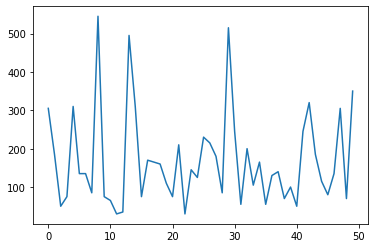

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [11]:
test()
load_replays()